Author: Monica Hannani<br>
Contact: mhannani@ukaachen.de<br>
Last updated: 2021-05-02

# Compositional data analysis on ageing marmoset kidneys with scCODA
Detection of shifts in cell type composition is not a trivial task for scRNA/snRNA-seq data. If a specific cell-type is depleted in one condition, the relative frequency of the other cell types will increase since there is a negative correlation between cell type proportions. Most statistical analyses (such as Wilcoxon rank sum tests) do not account for the negative correlation between cell type proportions and test for compositional changes <i>independently</i>. This can lead to inflation of differential cell types.<br>

Single cell compositional data analysis (scCODA) models cell type counts where the framework takes into account the negative correlation between cell type proportion but also the uncertainty of those proportions. The model assumes that only <i>a few</i> cell types will change in the condition state. scCODA needs a reference to identify compositional changes and relies on pre-defined and (most importantly) biologically meaningful annotations ([Büttner, Ostner et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.12.14.422688v2)).<br>

To test reliably for potential compositional shifts in ageing marmoset kidney snRNA-seq samples, we use scCODA. For this purpose, we use the young marmoset kidneys (<i>n</i> = 5) as the reference with high-level cell type annotations and compare with the old kidneys (<i>n</i> = 5).

In [2]:
# Initialize
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [5]:
# Read cell counts
indir = '/Users/monica/Dropbox/UKA/marmoset/'
cell_counts = pd.read_csv(indir + 'sample_cell_type_counts.csv')
print(cell_counts)

    sample_condition   PD    PT   DTL  LOH  DCT  CNT   IC   EC   FIB   IM  \
0         9857_young   67  2046   209  221  357  199  222  244    66   55   
1   9891_young_adult   45  2198   188  644  726  216  372  368   102   51   
2   9892_young_adult   52  1021   186  371  311  169  199  482   248   66   
3           9896_old   62  1428   309  144  224  500  347  525   614  110   
4           9899_old   34    81   712   69   66   51   60  349   574  150   
5           9903_old  118   690   326  447  446  649  343  361   540   98   
6           9904_old  374   425   209  203  414  856  507  306  1139   49   
7         9906_young   64  1464   117  232  379  252  216  209   104   49   
8   9908_young_adult   21  3503   113  351  551  330  280  250    71   44   
9         9912_young   74  2618   324  352  386  233  217  336   213  142   
10        9914_adult   17  6062   118  224  386  134  129  236    72  121   
11        9915_adult   24  3602   331  234  428  248  229  260    72  114   

In [13]:
# Convert data to anndata object and add condition
data = dat.from_pandas(cell_counts, covariate_columns = ['sample_condition'])
data.obs['condition'] = data.obs['sample_condition'].str.replace(r'\d+_', '')

First, we compare compositional changes between the young (<i>n</i> = 5) and the old (<i>n</i> = 5) marmoset kidneys. The normal stacked bar charts gives an early hint that there is a large decrease in the proximal tubular (PT) cell population but is missing important information - within-group variation.

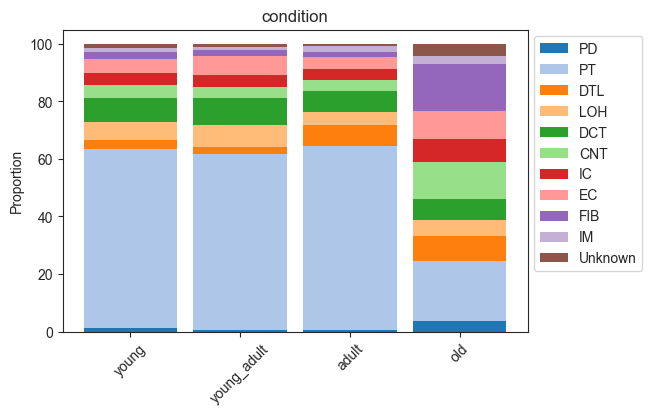

In [36]:
# Visualize cell type proportion in typical stacked boxplot
data.obs['condition'] = data.obs['condition'].astype('category').cat.reorder_categories(['young', 'young_adult', 'adult', 'old'])
viz.stacked_barplot(data, feature_name = 'condition')

If we look at the boxplots below for the young and old kidneys, showing within-group variation.

Trying to set attribute `.obs` of view, copying.


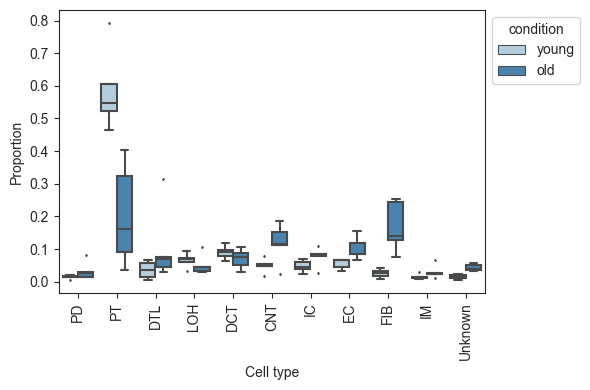

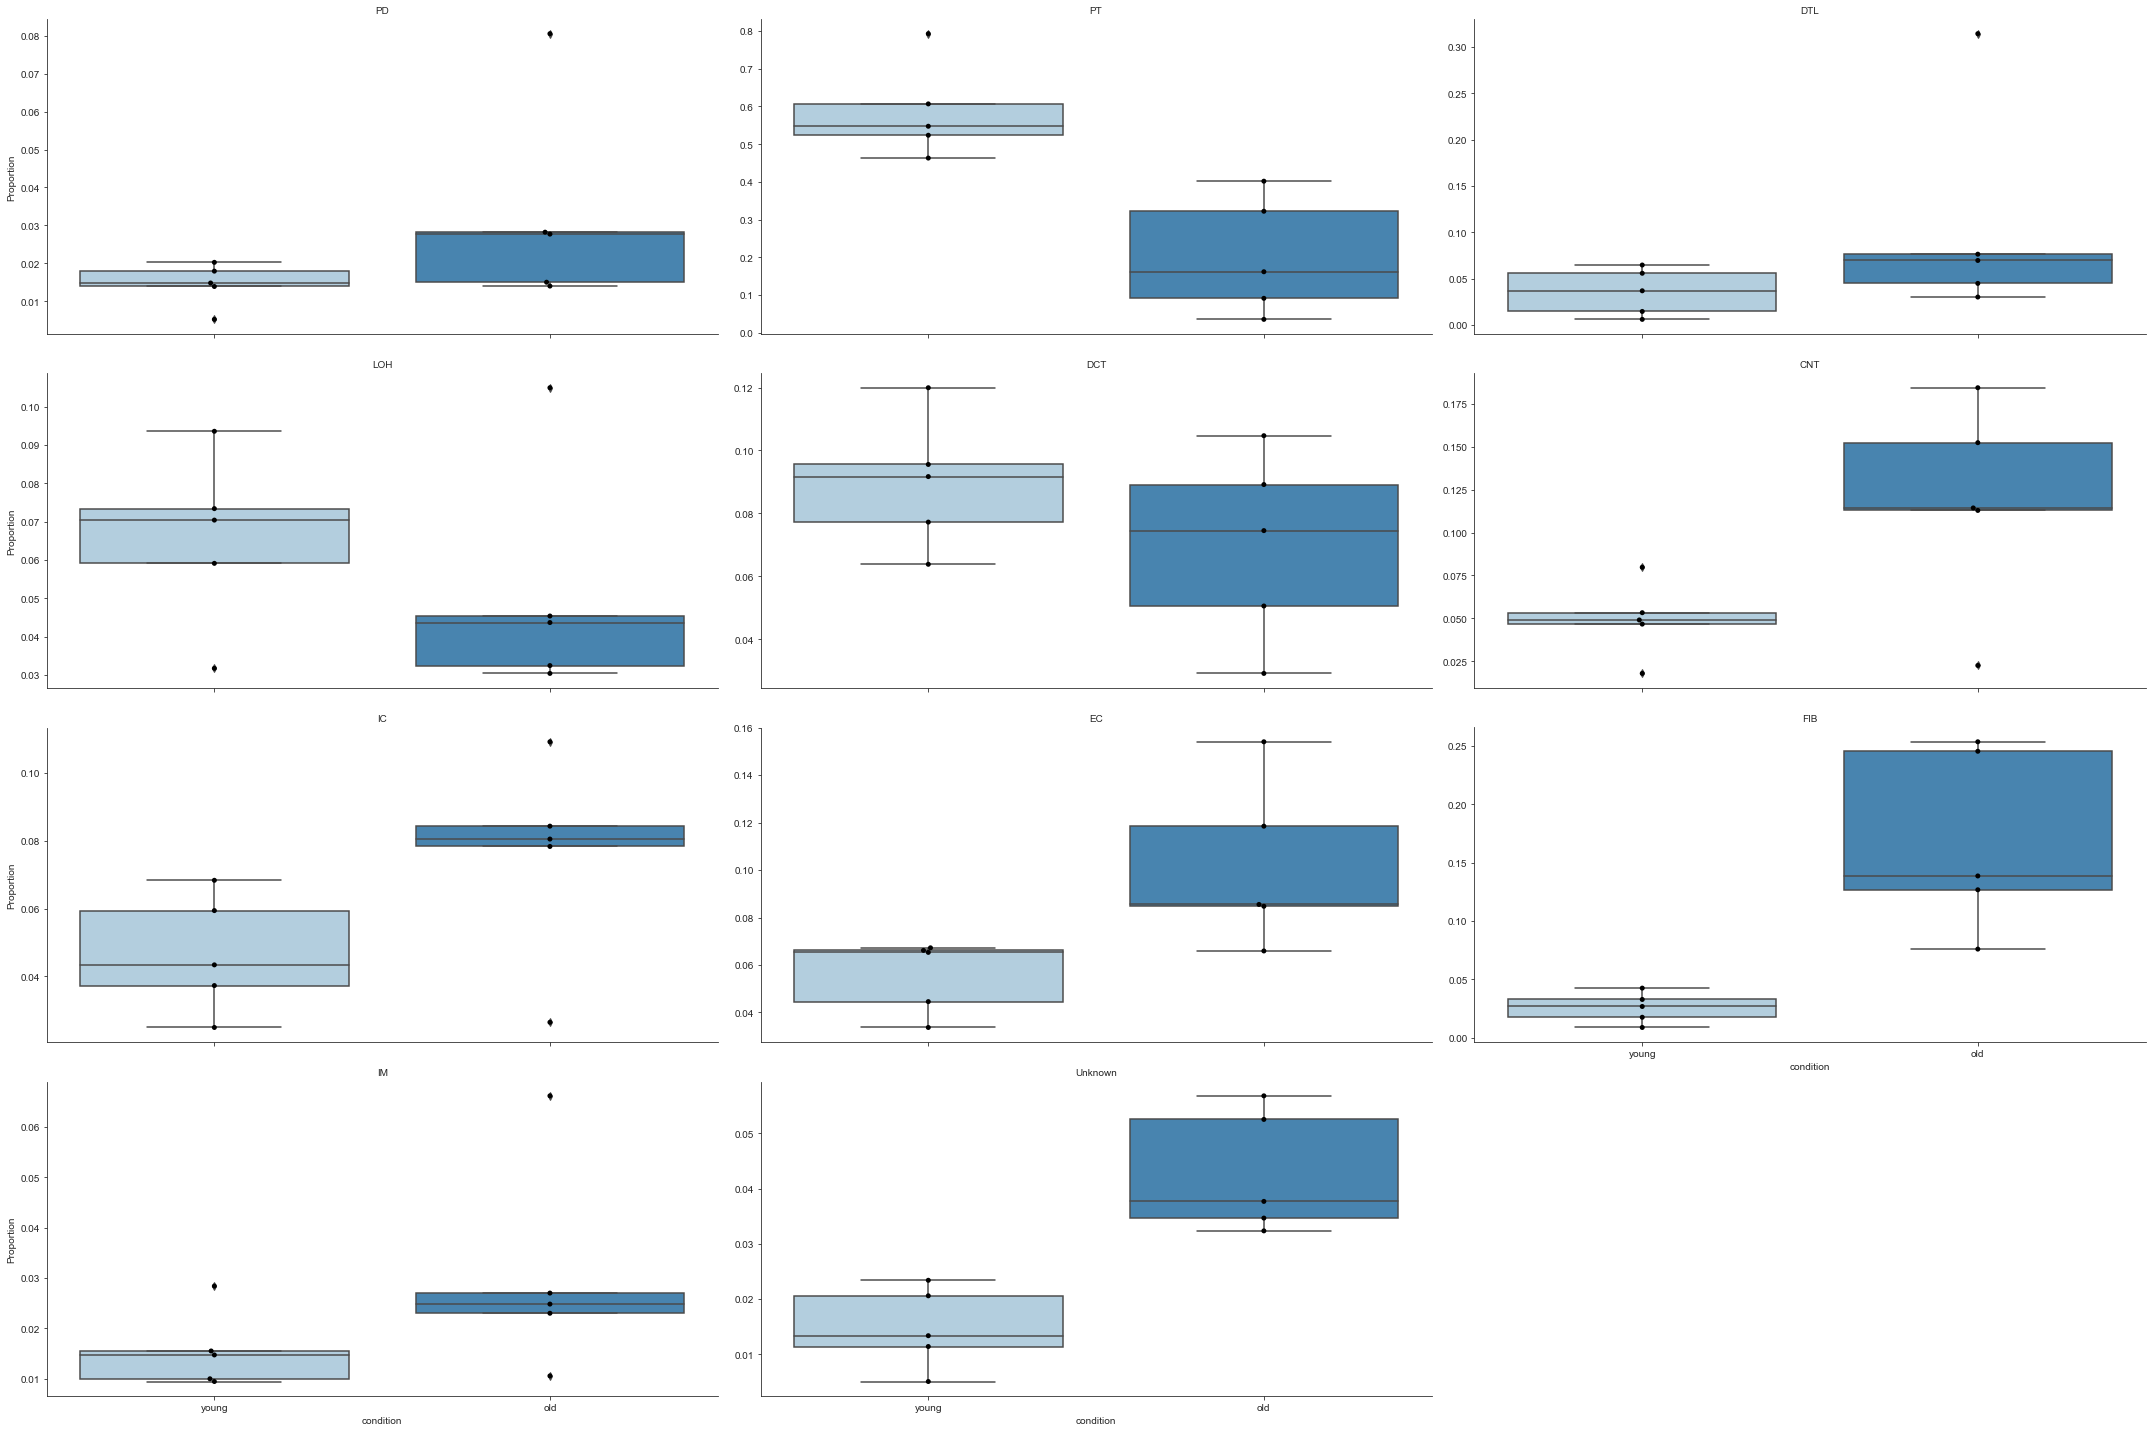

In [38]:
# Subset to young and old kidneys
case = 'old'
control = 'young'

# Subset
data_cond = data[data.obs['condition'].isin([case, control])]
data_cond.obs['condition'] = data_cond.obs['condition'].astype(str)
data_cond.obs['condition'] = data_cond.obs['condition'].astype('category').cat.reorder_categories([control, case])

# Visualize cell type proportions
viz.boxplots(data_cond, feature_name = 'condition')

viz.boxplots(data_cond, feature_name = 'condition',
             plot_facets = True,
             y_scale = 'relative',
             add_dots = True,
             cmap = 'Blues')

The above results indicate a large decrease in the PT cell population in the old kidneys (however with large within-group variation). This may have the effect of artificially increasing the proportion of many other cell types in the old kidney data such as the connecting tubular (CNT) cells, endothelial cells (EC), and fibroblasts (FIB). We therefore run scCODA to test more robustly if there is a compositional shift between the young and old kidneys.<br>

To create the model for the CODA we need to specify the covariates which in this case is the <i>condition</i>. For the model to run, we also need to specify a reference cell type. For this, we need to use a cell type that is not rare and that does not have a difference in relative abundance between the condition. The distal convoluted tubular (DCT) cell population was chosen as the reference cell type since there is relatively low within-group (with no extreme outliers) and between-group variation.

In [18]:
# Setup model
reference_cell_type = 'DCT'
model_cond = mod.CompositionalAnalysis(data_cond, formula = 'condition', reference_cell_type = reference_cell_type)

# Run Hamiltonian Monte Carlo (HMC) sampling for parameter inference (Markov chain Monte Carlo, MCMC)
sim_results = model_cond.sample_hmc()

MCMC sampling finished. (61.283 sec)
Acceptance rate: 54.0%


Now we can check out the model properties. The "Intercepts" show how the cell types are distributes without considering the covariate (i.e. condition). The "Effects" show how the covariate influences the cell types. The "Final Parameter" shows the inferred parameters used in the model, and in the "Effects" section this refers to all combinations of covariates and cell types. A value of zero means that there was no statistically credible effect detected by the model.<br>

Thus, when using DCTs as the reference cell type for scCODA, only 3 cell types exhibited a credible change in abundance in the old kidneys compared to young. For the PT and Loop of Henle (LOH) cells there was a decrease in abundance, and there was an increase in abundance of FIB in ageing marmoset kidneys. The log2-fold change gives an indication of the magnitude of change between the conditions. The change in the LOH population look questionable, which is also reflected in the log2-fold change.

In [20]:
sim_results.summary()

Compositional Analysis summary:

Data: 10 samples, 11 cell types
Reference index: 4
Formula: condition

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
PD                   0.149        94.152577
PT                   3.489      2656.903499
DTL                  0.765       174.324172
LOH                  1.210       272.031162
DCT                  1.260       285.978498
CNT                  1.127       250.364192
IC                   1.011       222.943110
EC                   1.231       277.804221
FIB                  0.587       145.899295
IM                   0.183        97.408807
Unknown              0.257       104.890466


Effects:
                            Final Parameter  Expected Sample  log2-fold change
Covariate        Cell Type                                                    
condition[T.old] PD                0.000000       174.871153          0.893220
                 PT               -1.852878       773.690502    

In [21]:
# Filter out credible effects
print(sim_results.credible_effects())

Covariate         Cell Type
condition[T.old]  PD           False
                  PT            True
                  DTL          False
                  LOH           True
                  DCT          False
                  CNT          False
                  IC           False
                  EC           False
                  FIB           True
                  IM           False
                  Unknown      False
Name: Inclusion probability, dtype: bool


In [23]:
# Save results
sim_results.save(indir + 'CoDa_young_vs_old')

## Differential cell type abundance testing with Wilcoxon rank sum test

Let's try testing for significant changes in the cell type proportions between the old and the young kidneys with a standard Wilcoxon rank sum test in `R`.

In [61]:
%load_ext rpy2.ipython

In [65]:
%%R
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))

# Read data
indir = '~/Dropbox/UKA/marmoset/'
setwd(indir)
sc = readRDS(file = 'marmoset.cca.integration.filter.reclust.annotated.rds')

In [72]:
%%R
# Summarize cell type counts for young and old kidney samples
sc$sample_condition = paste0(sc$sample, '_', sc$age_group)

cell_prop = sc@meta.data %>%
  filter(age_group %in% c('young', 'old')) %>%
  group_by(sample_condition) %>%
  dplyr::count(integrated_annotations_abbrev_top) %>% 
  group_by(sample_condition) %>% 
  mutate(prop = n/sum(n)) %>%
  as.data.frame()

# Wilcoxon rank sum test per cell type
cell_prop$condition = gsub('\\d+_', '', cell_prop$sample_condition)
cell.types = unique(cell_prop$integrated_annotations_abbrev_top)

p.values = c()
for (cell.type in cell.types){
  df = cell_prop %>%
    filter(integrated_annotations_abbrev_top == cell.type)
  
  p.values[[cell.type]] = wilcox.test(df$prop ~ df$condition)$p.value
}
p.values = unlist(p.values)
p.adjust(p.values, method = 'BH')

        PD         PT        DTL        LOH        DCT        CNT         IC 
0.20734127 0.02910053 0.20734127 0.42063492 0.34047619 0.17460317 0.17460317 
        EC        FIB         IM    Unknown 
0.08730159 0.02910053 0.27160494 0.02910053 


With the Wilcoxon rank sum test, there is a significant shift in the PTs and FIBs as well as the unknown cluster (have not been able to annotate properly yet).